# REINFORCE in Sonnet

This notebook implements a basic reinforce algorithm a.k.a. policy gradient for CartPole env.

It has been deliberately written to be as simple and human-readable.

Authors: [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team

The notebook assumes that you have [openai gym](https://github.com/openai/gym) installed.

In case you're running on a server, [use xvfb](https://github.com/openai/gym#rendering-on-a-server)

[2017-04-08 03:25:37,640] Making new env: CartPole-v0


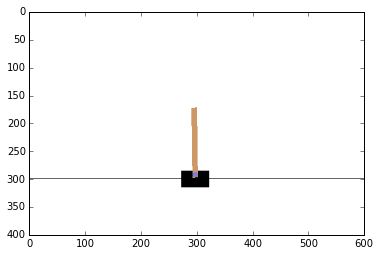

In [1]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

#gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [2]:
import tensorflow as tf
import sonnet as snt


#create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32',(None,)+state_dim,name="states")
actions = tf.placeholder('int32',name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [3]:

def make_network(inputs):
    
    lin1 = snt.Linear(output_size=100)(inputs)
    elu1 = tf.nn.elu(lin1)
    
    logits = snt.Linear(output_size=n_actions)(elu1)
    policy = tf.nn.softmax(logits)
    log_policy = tf.nn.log_softmax(logits)
    
    return logits, policy, log_policy

net = snt.Module(make_network,name="policy_network")

logits,policy,log_policy = net(states)

In [4]:
#utility function to pick action in one given state
get_action_proba = lambda s: policy.eval({states:[s]})[0] 

#### Loss function and updates

We now need to define objective and update over policy gradient.

The objective function can be defined thusly:

$$ J \approx \sum  _i log \pi_\theta (a_i | s_i) \cdot R(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [5]:
#REINFORCE objective function
actions_1hot = tf.one_hot(actions,n_actions)

log_pi_a = -tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=actions_1hot)

J = tf.reduce_mean(log_pi_a * cumulative_rewards)

In [6]:
#regularize with entropy
entropy = -tf.reduce_mean(policy*log_policy)

In [7]:
#all network weights
all_weights = net.get_variables()

#weight updates. maximizing J is same as minimizing -J
loss = -J -0.1*entropy
update = tf.train.AdamOptimizer().minimize(loss,var_list=all_weights)

### Computing cumulative rewards

In [8]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cumulative_rewards = []
    R = 0
    
    for r in rewards[::-1]:
        R = r + gamma*R
        cumulative_rewards.insert(0,R)
        
    return cumulative_rewards
    
    
    

In [9]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


In [10]:
def train_step(_states,_actions,_rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states:_states,actions:_actions,cumulative_rewards:_cumulative_rewards})

### Playing the game

In [11]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)
        
        a = np.random.choice(n_actions,p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    train_step(states,actions,rewards)
            
    return sum(rewards)
        

In [ ]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break
        


mean reward:27.590
mean reward:70.340
mean reward:129.570
mean reward:188.330
mean reward:211.530
mean reward:240.490
mean reward:235.760
mean reward:218.030
mean reward:258.470
mean reward:184.760
mean reward:298.920
mean reward:507.360
You Win!


### Results & video

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


[2017-04-08 03:29:10,315] Making new env: CartPole-v0
[2017-04-08 03:29:10,324] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-04-08 03:29:10,329] Clearing 6 monitor files from previous run (because force=True was provided)
[2017-04-08 03:29:10,336] Starting new video recorder writing to /home/jheuristic/Downloads/sonnet/sonnet/examples/videos/openaigym.video.0.14221.video000000.mp4
[2017-04-08 03:29:16,834] Starting new video recorder writing to /home/jheuristic/Downloads/sonnet/sonnet/examples/videos/openaigym.video.0.14221.video000001.mp4
[2017-04-08 03:29:23,689] Starting new video recorder writing to /home/jheuristic/Downloads/sonnet/sonnet/examples/videos/openaigym.video.0.14221.video000008.mp4


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [ ]:
#That's all, thank you for your attention!